In [11]:
import random
import pandas as pd
import yaml
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from modeling import ThreeLayerClassifier, AirYardsModel
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

team_rb_stats =  pd.read_csv('data/team_rb_stats.csv',index_col=0)
team_qb_stats= pd.read_csv('data/team_qb_stats.csv',index_col=0)
team_receiver_stats = pd.read_csv('data/team_receiver_stats.csv',index_col=0)

In [12]:
players = pd.read_parquet('data/agg/player_weekly_agg.parquet')


#players = player_stats.merge(players,left_on=['player_id','week','season'],right_on=['gsis_id','week','season'])

In [13]:
players.loc[(players.player_id=='00-0036322') & (players.season==2024)].iloc[-3]
# will ship '00-0039746'

season                                                                           2024
team_name                                                                         MIN
week                                                                             10.0
game_type                                                                         REG
depth_team                                                                        1.0
last_name                                                                   Jefferson
first_name                                                                     Justin
football_name                                                                  Justin
formation                                                                     Offense
gsis_id                                                                    00-0036322
jersey_number                                                                    18.0
position                                              

In [14]:
stat_cols = ['completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr']

In [15]:
class Player():
    def __init__(self, d):
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.depth_team= int(d['dense_depth'])
        self.stats = {x:0 for x in stat_cols}
        self.features= d.to_dict()

    def show_headshot(self):
        url = self.headshot_url
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis for cleaner display
        plt.show()

    def __getattr__(self, name):
            # Redirect attribute access to the stats dictionary
            if name in self.stats:
                return self.stats[name]
            elif name in self.features:
                return self.features[name]
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

In [16]:
class QB(Player):
    def __init__(self, d):  # noqa: F811
        super().__init__(d)
        self.name = d["full_name"]
        self.features= d.to_dict()

    def __repr__(self):
        return f"QB:{self.name} has {self.stats['completions']} completions for {self.pass_yards} yards"


class RB(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]
        self.features= d.to_dict()

    def __repr__(self):
        return f"RB:{self.name} has {self.carries} carries for {self.rushing_yards} yards"


class WR(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]


    def __repr__(self):
        return f"WR:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"
    
class TE(Player):
    def __init__(self, d):
        super().__init__(d)
        self.name = d["full_name"]
        self.id = d["gsis_id"]


    def __repr__(self):
        return f"TE:{self.name} has {self.receptions} receptions for {self.receiving_yards} yards"


class Team:
    def __init__(self, name: str, season: int, week: int, use_current_injuries=False):
        self.name = name
        self.score = 0
        self.plays = 0
        self.features = {
            'last_rusher_drive':-1,
            'last_rusher_team':-1
        }
        self.players = players.loc[
            (players.team_name == name) & (players.season == season)
        ]
        self.players = self.players.loc[
            (self.players.week == min(self.players.week.max(), week))
            & (self.players.formation == "Offense")
            & (self.players.position.isin(["QB", "WR", "TE", "RB"]))
        ].sort_values(by='dense_depth')

        self.QBs = self.get_players_by_position("QB")
        self.RBs = self.get_players_by_position("RB")
        self.WRs = self.get_players_by_position("WR")
        self.TEs = self.get_players_by_position("TE")
        self.rb_stats = team_rb_stats.loc[
            (team_rb_stats.team_name == name) & (team_rb_stats.season == season)
        ]
        self.rb_stats = self.rb_stats.loc[
            (self.rb_stats.week == min(self.rb_stats.week.max(), week))
        ].to_dict(orient='records')[0]

        self.team_receiver_stats = team_receiver_stats.loc[
            (team_receiver_stats.team_name == name) & (team_receiver_stats.season == season)
        ]
        self.team_receiver_stats = self.team_receiver_stats.loc[
            (self.team_receiver_stats.week == min(self.team_receiver_stats.week.max(), week))
        ].to_dict(orient='records')[0]

    def get_players_by_position(self, position: str):
        """Filter players by position and create player objects."""
        position_data = self.players[(self.players["position"] == position)].fillna(0)

        # Create player objects based on position
        players = []
        for _, player_data in position_data.iterrows():
            if position == "WR":
                players.append(WR(player_data))
            elif position == "RB":
                players.append(RB(player_data))
            elif position == "QB":
                players.append(QB(player_data))
            elif position == "TE":
                players.append(TE(player_data))
        return players
    
    def get_depth_pos(self, pos: str, depth: int):
        '''input a position and team depth, to get the player
            used to go from ML output -> player object'''
        if pos == 'WR':
            for player in self.WRs:
                if player.depth_team == depth:
                    return player
        if pos == 'RB':
            for player in self.RBs:
                if player.depth_team == depth:
                    return player
        if pos == 'TE':
            for player in self.TEs:
                if player.depth_team == depth:
                    return player
        raise ValueError('You want a player that does not exist')
    

    def __repr__(self):
        return f"{self.name} has {self.score} points"

In [17]:
vik = Team('PHI',2024, 12)
vik.RBs

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_28404\3056138231.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  position_data = self.players[(self.players["position"] == position)].fillna(0)


[RB:Saquon Barkley has 0 carries for 0 yards,
 RB:Kenneth Gainwell has 0 carries for 0 yards,
 RB:Will Shipley has 0 carries for 0 yards]

In [18]:
vik = Team('MIN',2024, 13)
det = Team('DET',2024, 13)
vik.players

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_28404\3056138231.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  position_data = self.players[(self.players["position"] == position)].fillna(0)
C:\Users\Sharedw\AppData\Local\Temp\ipykernel_28404\3056138231.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  position_data = self.players[(self.players["position"] == position)].fillna(0)


,season,team_name,week,game_type,depth_team,last_name,first_name,football_name,formation,gsis_id,...,attempts_roll,passing_2pt_conversions_roll,air_yards_share_roll,passing_air_yards_roll,carries_roll,receptions_roll,receiving_air_yards_roll,completions_roll,passing_first_downs_roll,sack_yards_roll
136032,2024,MIN,12.0,REG,1.0,Addison,Jordan,Jordan,Offense,00-0038994,...,0.000000,0.0,0.183940,0.000000,0.274091,1.927076,54.163275,0.000000,0.000000,0.000000
136290,2024,MIN,12.0,REG,1.0,Darnold,Sam,Sam,Offense,00-0034869,...,21.478367,0.0,0.000000,194.119457,3.915838,0.000000,0.000000,14.563688,8.742191,11.174907
139187,2024,MIN,12.0,REG,1.0,Jones,Aaron,Aaron,Offense,00-0033293,...,0.000000,0.0,0.010914,0.000000,11.145447,1.483595,3.623095,0.000000,0.000000,0.000000
140059,2024,MIN,12.0,REG,1.0,Hockenson,Thomas,T.J.,Offense,00-0035229,...,0.000000,0.0,0.061970,0.000000,0.000000,2.477064,20.504587,0.000000,0.000000,0.000000
135380,2024,MIN,12.0,REG,1.0,Jefferson,Justin,Justin,Offense,00-0036322,...,0.105993,0.0,0.227228,-0.529964,0.054078,4.151796,62.425460,0.105993,0.105993,0.000000
135624,2024,MIN,12.0,REG,2.0,Chandler,Ty,Ty,Offense,00-0037276,...,0.000000,0.0,-0.000926,0.000000,1.513088,0.118395,-0.289636,0.000000,0.000000,0.009878
137405,2024,MIN,12.0,REG,2.0,Oliver,Josh,Josh,Offense,00-0035249,...,0.000000,0.0,0.060237,0.000000,0.000000,1.986964,18.166955,0.000000,0.000000,0.000000
138507,2024,MIN,12.0,REG,2.0,Mullens,Nicholas,Nick,Offense,00-0033319,...,0.027591,0.0,0.000000,0.579407,0.014077,0.000000,0.000000,0.027591,0.027591,0.000000
135558,2024,MIN,12.0,REG,3.0,Rypien,Brett,Brett,Offense,00-0034955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135718,2024,MIN,12.0,REG,3.0,Mundt,Johnny,Johnny,Offense,00-0033246,...,0.000000,0.0,0.021434,0.000000,0.000000,0.642915,5.253250,0.000000,0.000000,0.000000


In [19]:
vik.WRs[1].features

{'season': 2024,
 'team_name': 'MIN',
 'week': 12.0,
 'game_type': 'REG',
 'depth_team': 1.0,
 'last_name': 'Jefferson',
 'first_name': 'Justin',
 'football_name': 'Justin',
 'formation': 'Offense',
 'gsis_id': '00-0036322',
 'jersey_number': 18.0,
 'position': 'WR',
 'elias_id': 'JEF269287',
 'depth_position': 'WR',
 'full_name': 'Justin Jefferson',
 'dense_depth': 1.0,
 'player_id': '00-0036322',
 'player_name': 0,
 'player_display_name': 'Justin Jefferson',
 'position_group': 'WR',
 'headshot_url': 'https://static.www.nfl.com/image/upload/f_auto,q_auto/league/vrftbpzwk6qmv0zjcysg',
 'season_type': 0,
 'fantasy_points_roll': 6.607378636295939,
 'target_share_roll': 0.1956112809439475,
 'receiving_first_downs_roll': 2.7254589713264563,
 'passing_yards_roll': 2.3318425908538942,
 'rushing_first_downs_roll': 0.0,
 'receiving_yards_after_catch_roll': 14.372067767139441,
 'rushing_yards_roll': 0.16223394648797967,
 'targets_roll': 5.835445685350682,
 'fantasy_points_ppr_roll': 10.75917470

In [20]:
model_path = "models/run_yards_gained.pt"
run_yards_model = ThreeLayerClassifier()
run_yards_model.load_state_dict(torch.load(model_path, weights_only=True))

air_yards_path = "models/air_yards.pt"
air_yards_model = AirYardsModel()
air_yards_model.load_state_dict(torch.load(air_yards_path, weights_only=True))

<All keys matched successfully>

In [44]:
class GameState:


	def __init__(self, home, away, config):
		self.home =home
		self.away = away
		self.quarter = 1
		self.possession = None
		self.down = 1
		self.ydstogo = 10
		self.ball_position = 65  # Yardline (0-100), 0 is score, 100 is safety
		self.clock = 900  # Seconds in the current quarter (15 mins = 900 seconds)
		self.drive = 0
		self.home_timeouts = 3
		self.away_timeouts = 3
		self.pbp = []
		self.player = None
		self.run_or_pass = joblib.load('models/run_or_pass.joblib')
		self.run_or_pass_cols = config['run_or_pass_cols']
		self.choose_rusher = joblib.load('models/choose_rusher.joblib')
		self.choose_rusher_cols = config['choose_rusher_cols']
		self.choose_receiver = joblib.load('models/choose_receiver.joblib')
		self.choose_receiver_cols = config['choose_receiver_cols']
		self.air_yards_cols = config['air_yards_cols']
		self.receiver_idx_to_pos = config['receiver_idx_to_pos']
		self.rush_yard_cols = config['rush_yard_cols']
		self.play_encoding = config['play_encoding']
		self.wind = random.randint(0,10)
		self.temp = random.randint(40,90)
		self.play_functions = {
			'field_goal': self.field_goal,
			'no_play': self.run_play,
			'pass': self.pass_play,
			'punt': self.punt,
			'qb_kneel': self.qb_kneel,
			'qb_spike': self.qb_spike,
			'run': self.run_play
			}
		
		
	def switch_poss(self):
		self.possession.features['last_rusher_drive'] = -1
		self.possession = self.away if self.possession == self.home else self.home 
		self.ball_position = 100 - min(self.ball_position, 99)
		self.down = 1
		self.ydstogo = min(10, self.ball_position)
		self.drive += 1
		return
	
	def kickoff(self):
		self.switch_poss()
		self.ball_position = 65
		pass
	
	def start_game(self):
		lost_kickoff = random.choice((self.home, self.away))
		self.possession=lost_kickoff
		self.kickoff()
		print(f'{self.possession.name} has won the kickoff')
		self.log_play('kickoff',0)

	def play(self, team):
		team.plays += 1
		features = [self.pbp[-1][key] for key in self.run_or_pass_cols]
		preds = self.run_or_pass.predict_proba([features])
		play_type_int = np.random.choice(len(preds[0]), p=preds[0])
		play_type = self.play_encoding.get(play_type_int, 1)
		yds = self.play_functions[play_type](team)
		self.log_play(play_type, yds)
		self.ydstogo -= yds
		self.ball_position -= yds
		self.clock -= random.randint(10, 40)
		self.td_check(team)
		self.check_downs(team)


	def log_play(self,play_type, yds,verbose=False):
		"""Logs the context of the game state at each play."""
		play_data = {
			"possession": self.possession.name,
			"quarter": self.quarter,
			"down": self.down,
			"ydstogo": self.ydstogo,
			"goal_to_go": int(self.ball_position < 10),
			"yardline_100": self.ball_position,
			"total_home_score": self.home.score,
			"total_away_score": self.away.score,
			"posteam_score": self.possession.score,
			"defteam_score": self.home.score if self.possession == self.away else self.away.score,
			"score_differential": (self.home.score - self.away.score),
			"wind": self.wind,
			"temp": self.temp,
			"quarter_seconds_remaining": self.clock,
			'half_seconds_remaining': self.clock + (900 * (self.quarter%2)),
    		'game_seconds_remaining': self.clock + (900 * (4-self.quarter)),
			'drive':self.drive,
			'spread_line':-2.5,
			'total_line': 42.5,
			'play_type': play_type,
			'yards_gained': yds,
			'player': self.player
		}
		if verbose:
			print(
				f'{self.possession.name} {play_type} for {yds} yards, {self.pbp[-1]['yardline_100']} yd line,' + 
				f' {self.pbp[-1]['ydstogo']} yds to go on {self.pbp[-1]['down']} down.' + 
				f' {self.pbp[-1]['quarter_seconds_remaining'] // 60}:{self.pbp[-1]['quarter_seconds_remaining']  % 60} left'
			)
		self.pbp.append(play_data)


	
	def sample_run_yards(self, model, player):
		#rush_yards_cols = self.rush_yards_cols
		raw_features = dict(self.pbp[-1])
		raw_features.update(player.features)
		x = [raw_features[key] for key in self.rush_yard_cols]
		x = torch.tensor(x)
		with torch.no_grad():
			preds = model(x.reshape(1,-1))[0]
			preds = torch.softmax(preds,0)
		sample = (torch.multinomial(preds,1)).item() - 5
		return min((sample, raw_features['yardline_100']))

	def sample_air_yards(self, model, player):
		raw_features = dict(self.pbp[-1])
		raw_features.update(player.features)
		x = [raw_features[key] for key in self.air_yards_cols]
		x = torch.tensor(x)
		with torch.no_grad():
			preds = model(x.reshape(1,-1))[0]
			preds = torch.softmax(preds,0)
		sample = (torch.multinomial(preds,1)).item() - 20
		return min((sample, raw_features['yardline_100']))
		

	def run_play(self, team):
		raw_features = dict(self.pbp[-1])
		raw_features.update(team.rb_stats)
		raw_features.update(team.features)
		features = [raw_features[key] for key in self.choose_rusher_cols]
		preds = self.choose_rusher.predict_proba([features])
		rusher_depth = np.random.choice(len(preds[0]), p=preds[0])
		player = team.get_depth_pos('RB', int(rusher_depth))
		player.carries += 1
		yds = self.sample_run_yards(run_yards_model, player)
		player.rushing_yards += yds
		self.player = player.name
		team.features['last_rusher_team'] = rusher_depth
		team.features['last_rusher_drive'] = rusher_depth
		return yds

	def pass_play(self, team):
		passer = team.QBs[0]

		raw_features = dict(self.pbp[-1])
		raw_features.update(vik.team_receiver_stats)
		raw_features.update(vik.features)
		features = [raw_features[key] for key in self.choose_receiver_cols]
		preds = self.choose_receiver.predict_proba([features])
		receiver = np.random.choice(len(preds[0]), p=preds[0])
		pos, depth = self.receiver_idx_to_pos[receiver].split('_')
		receiver = team.get_depth_pos(pos, int(depth))
		passer.attempts += 1
		receiver.targets += 1
		if random.randint(0, 100) > 30:
			passer.completions += 1
			receiver.receptions += 1
			air_yards = self.sample_air_yards(air_yards_model, receiver)
			yds = air_yards + random.randint(-2, 5)
			receiver.receiving_yards += yds
			passer.passing_yards += yds
		else:
			yds = 0
		self.player = receiver.name
		return yds
	
	
	def punt(self, team):
		self.switch_poss()
		self.ball_position += random.randint(30, 60)
		if self.ball_position >= 100:
			self.ball_position = 20
		self.player=None
		return 0
	
	def field_goal(self,team):
		result = random.randint(0,100)
		if result > (2 * self.ball_position):
			team.score += 3
			self.switch_poss()
			self.ball_position = 65
			print(f'{team.name} scored a FG')
		else:
			print(f'{team.name} missed FG')
			self.switch_poss()
		self.player=None
		return 0
	
	def qb_kneel(self, team):
		# Implementation of qb kneel play
		print("QB kneel executed.")
		return -1

	def qb_spike(self, team):
		# Implementation of qb spike play
		print("QB spike executed.")
		return 0
	
	def td_check(self, team):
		if self.ball_position <= 0:
			team.score += 7
			self.kickoff()
			print(f'{team.name} scored a TD')
		return
	
	def check_downs(self, team):
		if self.ydstogo <= 0:
			self.ydstogo = 10
			self.down = 1
		elif self.down == 4:
			self.switch_poss()
		else:
			self.down += 1


	def play_quarter(self):
		self.clock = 900
		while self.clock > 0:
			self.play(self.possession)
		self.quarter += 1
		print(f'{self.home.name}:{self.home.score}')
		print(f'{self.away.name}:{self.away.score}')

	def play_game(self):
		while self.quarter <= 4:
			self.play_quarter()
			print(self.quarter)


In [45]:
vik.WRs[0].features

{'season': 2024,
 'team_name': 'MIN',
 'week': 12.0,
 'game_type': 'REG',
 'depth_team': 1.0,
 'last_name': 'Addison',
 'first_name': 'Jordan',
 'football_name': 'Jordan',
 'formation': 'Offense',
 'gsis_id': '00-0038994',
 'jersey_number': 3.0,
 'position': 'WR',
 'elias_id': 'ADD491056',
 'depth_position': 'WR',
 'full_name': 'Jordan Addison',
 'dense_depth': 0.0,
 'player_id': '00-0038994',
 'player_name': 0,
 'player_display_name': 'Jordan Addison',
 'position_group': 'WR',
 'headshot_url': 'https://static.www.nfl.com/image/upload/f_auto,q_auto/league/tmyckmignrvy8truccwm',
 'season_type': 0,
 'fantasy_points_roll': 5.160700753463429,
 'target_share_roll': 0.12175776496240573,
 'receiving_first_downs_roll': 1.2944278405490064,
 'passing_yards_roll': 0.0,
 'rushing_first_downs_roll': 0.019707719447033496,
 'receiving_yards_after_catch_roll': 8.516159512789827,
 'rushing_yards_roll': 1.6854495736959099,
 'targets_roll': 3.7056071940074964,
 'fantasy_points_ppr_roll': 7.0877770983957,

In [46]:
with open('models/feature_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

vik = Team('MIN',2024, 13)
det = Team('HOU',2024, 13)
game = GameState(vik, det, config)
game.start_game()
game.play_game()


C:\Users\Sharedw\AppData\Local\Temp\ipykernel_28404\3056138231.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  position_data = self.players[(self.players["position"] == position)].fillna(0)
C:\Users\Sharedw\AppData\Local\Temp\ipykernel_28404\3056138231.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  position_data = self.players[(self.players["position"] == position)].fillna(0)


HOU has won the kickoff
HOU scored a FG
HOU missed FG
MIN scored a TD
MIN:7
HOU:3
2
MIN missed FG
MIN missed FG
HOU scored a TD
MIN missed FG
HOU scored a TD
MIN scored a TD
HOU missed FG
MIN:14
HOU:17
3
QB spike executed.
MIN scored a TD
MIN:21
HOU:17
4
MIN missed FG
MIN missed FG
HOU scored a TD
MIN scored a TD
MIN scored a TD
HOU missed FG
MIN:35
HOU:24
5


In [24]:
for i in range(10):
    game = GameState(vik, det, config)
    game.start_game()
    game.play_game()
    game.home.score=0
    game.away.score=0

HOU has won the kickoff
[18, 2, 0, 6, 45, -10, 794, 1694, 3494, 9, 75, -2.5, 42.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 4
HOU scored a TD
[63, 3, 0, 8, 35, -17, 674, 1574, 3374, 9, 75, -2.5, 42.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 14
[20, 1, 0, 10, 52, -17, 629, 1529, 3329, 9, 75, -2.5, 42.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 4
MIN missed FG
HOU scored a TD
[64, 3, 0, 9, 35, -24, 360, 1260, 3060, 9, 75, -2.5, 42.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 16
[20, 2, 0, 10, 59, -24, 291, 1191, 2991, 9, 75, -2.5, 42.5, 0.0, 0.0, 0.0, 0.0, 0.0

In [35]:
vik.WRs + vik.TEs

[WR:Jordan Addison has 6 receptions for 77 yards,
 WR:Justin Jefferson has 8 receptions for 76 yards,
 WR:Jalen Nailor has 0 receptions for 0 yards,
 WR:Brandon Powell has 0 receptions for 0 yards,
 WR:Trent Sherfield has 0 receptions for 0 yards,
 TE:T.J. Hockenson has 2 receptions for 23 yards,
 TE:Josh Oliver has 0 receptions for 0 yards,
 TE:Johnny Mundt has 0 receptions for 0 yards]

In [17]:
print(game.away.plays, game.home.plays)

7434 7294


In [18]:
pbp = pd.json_normalize(game.pbp)
pbp

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,...,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,spread_line,total_line,play_type,yards_gained,player
0,HOU,1,1,10,0,65,0,0,0,0,...,85,900,1800,3600,1,-2.5,42.5,kickoff,0,None
1,HOU,1,1,10,0,65,0,0,0,0,...,85,900,1800,3600,1,-2.5,42.5,run,0,Joe Mixon
2,HOU,1,2,10,0,65,0,0,0,0,...,85,884,1784,3584,1,-2.5,42.5,run,0,Joe Mixon
3,HOU,1,3,10,0,65,0,0,0,0,...,85,853,1753,3553,1,-2.5,42.5,run,8,Joe Mixon
4,HOU,1,4,2,0,57,0,0,0,0,...,85,818,1718,3518,1,-2.5,42.5,pass,0,Xavier Hutchinson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,HOU,4,1,10,0,90,38,31,31,7,...,85,68,68,68,41,-2.5,42.5,punt,0,None
139,HOU,4,2,10,0,90,38,31,31,7,...,85,57,57,57,41,-2.5,42.5,qb_kneel,-1,None
140,HOU,4,3,11,0,91,38,31,31,7,...,85,43,43,43,41,-2.5,42.5,run,4,Joe Mixon
141,HOU,4,4,7,0,87,38,31,31,7,...,85,33,33,33,41,-2.5,42.5,qb_kneel,-1,Joe Mixon


In [19]:
vik.RBs[0].receptions

32

In [20]:
vik.WRs

[WR:Jordan Addison has 620 receptions for 8539 yards,
 WR:Justin Jefferson has 1127 receptions for 16809 yards,
 WR:Jalen Nailor has 207 receptions for 3055 yards,
 WR:Brandon Powell has 29 receptions for 503 yards,
 WR:Trent Sherfield has 10 receptions for 168 yards]

In [21]:
det.WRs

[WR:Robert Woods has 563 receptions for 8050 yards,
 WR:Xavier Hutchinson has 1062 receptions for 14875 yards,
 WR:Tank Dell has 199 receptions for 2906 yards,
 WR:John Metchie has 21 receptions for 288 yards,
 WR:Steven Sims has 10 receptions for 78 yards]

In [22]:
det.TEs

[TE:Dalton Schultz has 181 receptions for 2474 yards,
 TE:Cade Stover has 6 receptions for 113 yards,
 TE:Teagan Quitoriano has 3 receptions for 31 yards]

In [23]:
pbp.loc[(pbp.possession=='LA')].sort_values(by='yardline_100')

,possession,quarter,down,ydstogo,goal_to_go,yardline_100,total_home_score,total_away_score,posteam_score,score_differential,...,temp,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,spread_line,total_line,play_type,yards_gained,player


In [24]:
game.home.RBs[0].features

{'season': 2024,
 'team_name': 'MIN',
 'week': 12.0,
 'game_type': 'REG',
 'depth_team': 1.0,
 'last_name': 'Jones',
 'first_name': 'Aaron',
 'football_name': 'Aaron',
 'formation': 'Offense',
 'gsis_id': '00-0033293',
 'jersey_number': 33.0,
 'position': 'RB',
 'elias_id': 'JON026624',
 'depth_position': 'RB',
 'full_name': 'Aaron Jones',
 'dense_depth': 0.0,
 'player_id': '00-0033293',
 'player_name': 0,
 'player_display_name': 'Aaron Jones',
 'position_group': 'RB',
 'headshot_url': 'no_url',
 'season_type': 0,
 'receptions_roll': 0.0,
 'rushing_tds_roll': 0.0,
 'passing_2pt_conversions_roll': 0.0,
 'rushing_first_downs_roll': 0.0,
 'carries_roll': 0.0,
 'target_share_roll': 0.0,
 'air_yards_share_roll': 0.0,
 'receiving_air_yards_roll': 0.0,
 'interceptions_roll': 0.0,
 'passing_yards_roll': 0.0,
 'passing_first_downs_roll': 0.0,
 'rushing_yards_roll': 0.0,
 'fantasy_points_roll': 0.0,
 'passing_tds_roll': 0.0,
 'sack_yards_roll': 0.0,
 'passing_yards_after_catch_roll': 0.0,
 'rece

In [25]:
raw_features = dict(game.pbp[-1])
raw_features.update(game.home.RBs[0].features)


In [26]:
x = [raw_features[key] for key in game.rush_yard_cols]

In [27]:
x = torch.tensor(x)
x

tensor([10.0000, 20.0000,  1.0000,  0.0000, 31.0000,  7.0000, -2.5000, 42.5000,
         0.0000,  0.0000,  0.0000])

In [28]:
def sample_run_yards(self, model, player):
    raw_features = dict(self.pbp[-1])
    raw_features.update(player.features)
    x = [raw_features[key] for key in game.rush_yard_cols]
    x = torch.tensor(x)
    with torch.no_grad():
        preds = model(x.reshape(1,-1))[0]
        preds = torch.softmax(preds,0)
    sample = torch.multinomial(preds,10) + 5
    return (sample, raw_features['yardline_100'])

sample_run_yards(game, model, vik.RBs[0])

NameError: name 'model' is not defined

In [ ]:
with torch.no_grad():
    preds = model(x.reshape(1,-1))[0]
    #preds = torch.sigmoid(preds)

In [ ]:
sig_preds= torch.sigmoid(preds)
soft_preds = torch.softmax(preds,0)

In [ ]:
samples = torch.multinomial(sig_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)0633

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (763450157.py, line 4)

(array([0.001, 0.   , 0.003, 0.006, 0.008, 0.034, 0.05 , 0.136, 0.099,
        0.663]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 <BarContainer object of 10 artists>)

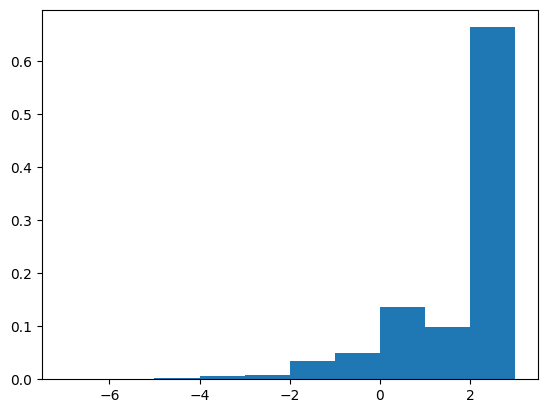

In [ ]:
samples = torch.multinomial(soft_preds,1000,replacement=True) - 20
samples = torch.clamp(samples, max=3)
import matplotlib.pyplot as plt
plt.hist(samples,density=True)